# Acquire, visualize and analyze Online Data

In this chapter the [**ArcGIS API for Python**](https://developers.arcgis.com/python/) and the [**ArcGIS Rest API**](https://developers.arcgis.com/rest/) are used to acquire Data from ArcGIS Online. Feature Layers from online sources are visualized in a Map Widget directly in the Notebook. The functionality of the spatially enabled dataframe is briefly explained (utilizing [**pandas**](https://pandas.pydata.org/) and [**Matplotlib**](https://matplotlib.org/)). The tools and workflows demonstrated in this Notebook act as a great interfaced to common data science and statistics modules in Python. Workflows written in Python can easily be a automated to plot, update, or export data.

**Index**
1. [ArcGIS API](#ArcGIS-API-for-Python)
2. [Describe the Data](#Describe-the-Data)
3. [Add Layer to Map Widget](#Add-Layer-to-Map-Object)
4. [Using spatially enabled DataFrames](#Using-spatially-enabled-DataFrame)
5. [Python Libraries](#Utilizing-Python-libraries)
6. [Updating Data online](#Utilizing-Python-libraries)
7. [REST Interface](#REST-requests)


In [222]:
from IPython.core.display import display, HTML
%matplotlib inline
from datetime import datetime as dt

## ArcGIS API for Python

Loading ArcGIS API of Python and signing in.
Previously stored log-in credentials in the profile "COVdemo". More information [here](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/).

In [233]:
from arcgis.gis import GIS
gis = GIS(profile="COVdemo")
#gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123")

The dataset has been created in the [previous Chapter](03a_publish_data_into_arcgis.com.ipynb) and can be found online [here](https://ag.maps.arcgis.com/home/item.html?id=04f9d3bf38544af882ee14eecbdf99f1). From the URL the dataset ID can be extracted ![Overview](img/04b_url_id.png) 

In [234]:
covid_data_id = '04f9d3bf38544af882ee14eecbdf99f1'

Using the [```gis``` module](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#gis) to get the dataset.

<Item title:"CovDemo1" type:Feature Layer Collection owner:MBennTLL>
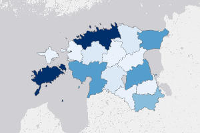

In [235]:
data_item = gis.content.get(covid_data_id)
data_item

## Describe the Data

Acquired item has several properties, which are referenced in the [online documentation](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#item). It is possible to get meta data.

- **What is the summary of the data?**

In [114]:
display(HTML(data_item.description))

- **Who owns the dataset and is it shared with *everyone*?**

In [117]:
print("Owner: {}, shared with everyone: {}".format(data_item.owner, data_item.shared_with['everyone']))

Owner MBennTLL, shared with everyone: False


- **How often has it been used in the last 24H?**

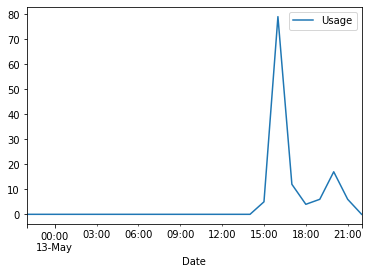

In [221]:
data_item.usage(date_range='24H', as_df=True).set_index('Date').plot()

- **How many layers and tables are in the dataset?**

In [120]:
print("The dataset has {} layer and {} tables.".format(len(data_item.tables),len(data_item.layers)))

The dataset has 2 layer and 2 tables.


- **How are they named?**

In [130]:
for lyr in data_item.layers:
    print(lyr.properties.name)
for lyr in data_item.tables:
    print(lyr.properties.name)

County Riskgroup
County Timeseries
County Agegroups
Estonia Timeseries


## Add Layer to Map Object

It is possible to select a single layer from the dataset, by using the respective index 

In [133]:
flayer1 = data_item.layers[0]
print('Selected layer: {}'.format(flayer1.properties.name))

Selected layer: County Riskgroup


Map widgets can be included directly in Jupyter notebook. 

In [246]:
map1 = gis.map() # create map  object
map1.extent = data_item.extent # zoom to dataset extend
map1

MapView(layout=Layout(height='400px', width='100%'))

When the Widget is created and displayed, it is possible to add the selected layer to it.

In [247]:
map1.add_layer(flayer1) # add data to the map object

In [ ]:
#map1.legend = True

Information on how the layer is displayed, what content it has is part of the ```properties``` class. 

In [248]:
props = agegroup_flayer.properties

In [249]:
report = "The name of the Layer is: {}. \nIt has {} fields and was last edited: {}"
print(report.format(   props.name,
                       len(props.fields),
                       dt.fromtimestamp(props.editingInfo.lastEditDate/1000)))

The name of the Layer is: County Riskgroup. 
It has 64 fields and was last edited: 2020-05-03 23:13:28.031000


**Search for more content to add**

In [250]:
search_result = gis.content.search(query="title:Apteegi*", outside_org=True, item_type="Feature *")
for item in search_result:
    print("Layer {} by {}".format(item.name, item.owner))

Layer Apteegireform by Kristiins11
Layer None by Hendrikson
Layer Eesti_apteegid_2020 by silver.savi
Layer Apteegiteenuse kättesaadavus (sõiduaeg 30 min) by rsuurna


Adding the first (```[0]```) first item to the map.

In [251]:
map1.add_layer(search_result[0])

**Publishing the Map Online**

In [252]:
webmap_item_properties = {'title':'Riskgroups and Pharmacies',
                         'snippet':'Map created using Python API showing locations of Pharmacies',
                         'tags':['covid', 'risk', 'apteegi', 'python']}
webmap_online = map1.save(webmap_item_properties)
webmap_online

<Item title:"Riskgroups and Pharmacies" type:Web Map owner:MBennTLL>

In [253]:
print(webmap_online.shared_with)

{'everyone': False, 'org': False, 'groups': []}


In [254]:
webmap_online.share(everyone=True)

{'results': [{'itemId': 'a3e7591684f44240a609ff9d2f88e13f',
   'success': True,
   'notSharedWith': []}]}

In [255]:
print(webmap_online.shared_with)

{'everyone': True, 'org': True, 'groups': []}


In [216]:
webmap_online.delete()

True

## Using spatially enabled DataFrame 

Data that is saved online can be accessed in different ways. One way is to utilize spatiall enabled DataFrames (which are based on pandas). More information on how to access data [here](https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/)

In [236]:
flayer2 = data_item.layers[1]
print('Selected layer: {}'.format(flayer2.properties.name))

Selected layer: County Timeseries


Check what kind of *rights* are set on the Layer.

In [237]:
counties_flayer.properties.capabilities

'Query'

Next, using a SQL-like query, a subset of the layer will be created, the subset can be displayed as a spatially enabled dataframe (sdf), which contains an additional field for the ```SHAPE```.

In [41]:
counties_fset = counties_flayer.query(where="MKOOD LIKE \'0037\'") # 
counties_fset.sdf.head()

,OBJECTID,StatisticsDate,negativeTests,confirmedCases,testsPerDay,cumulativeNegative,cumulativePositive,testsPerformed,positiveTestsPerc,positiveTestsPercCum,lastFeature,cumulativePosPer10K,testedPerfPerPop10K,MKOOD,County,Shape__Area,Shape__Length,SHAPE
0,115,2020-03-02,20,0,20,76,1,77,0.0000,0.0130,NaN,0.0,1.3,0037,Harju maakond,4.304678e+09,612791.789553,"{'rings': [[[499858.453000002, 6578955.264], [..."
1,116,2020-03-03,23,0,23,99,1,100,0.0000,0.0100,NaN,0.0,1.7,0037,Harju maakond,4.304678e+09,612791.789553,"{'rings': [[[499858.453000002, 6578955.264], [..."
2,117,2020-03-04,26,1,27,125,2,127,0.0370,0.0157,NaN,0.0,2.2,0037,Harju maakond,4.304678e+09,612791.789553,"{'rings': [[[499858.453000002, 6578955.264], [..."
3,118,2020-03-05,23,6,29,148,8,156,0.2069,0.0513,NaN,0.1,2.7,0037,Harju maakond,4.304678e+09,612791.789553,"{'rings': [[[499858.453000002, 6578955.264], [..."
4,119,2020-03-06,66,0,66,214,8,222,0.0000,0.0360,NaN,0.1,3.8,0037,Harju maakond,4.304678e+09,612791.789553,"{'rings': [[[499858.453000002, 6578955.264], [..."


The (pandas-based) dataframe has (Matplotlib) plotting capabilities enabled.

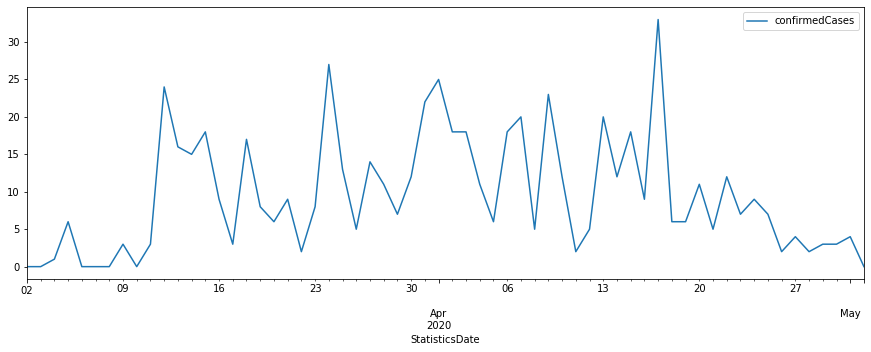

In [89]:
df = counties_fset.sdf[['confirmedCases', 'StatisticsDate']].set_index('StatisticsDate')
df.plot(figsize=(15,5))

## Utilizing Python libraries

The dataframe can easily be passed on to further python data science and statistics modules 

- [sklearn](https://scikit-learn.org/stable/), 
[statsmodels](https://www.statsmodels.org/stable/index.html), [cesium](http://cesium-ml.org/), [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) ...

and then published back to ArcGIS Online using this **ArcGIS API for Python**.

# REST requests

Another way of acquiring data from online resources is the [REST API](https://developers.arcgis.com/rest/), which might be more resource-friendly and also platform independent (e.g. where ```arcgis``` cannot be installed). The REST API can be accessed by simple HTTP requests.

In [51]:
import requests
import pandas as pd

This is the url of the agegroup layer.

In [61]:
url = r'https://services.arcgis.com/yp7JCKsp46eWsUfk/arcgis/rest/services/CovDemo1/FeatureServer/0/query?'

A token is necessary to access the data (login credentials). Token has been created with another Python script.

In [62]:
with open( r'tokenfile_agol.txt', 'r') as outfile:
    tk = outfile.readline()

Define the Payload which is send via [HTTP GET](https://www.w3schools.com/tags/ref_httpmethods.asp).

In [240]:
payload= {'where': '1=1' ,
           'returnGeometry': False,
           'outFields': 'TOTAL,M_TOTAL,F_TOTAL,MKOOD',
           'f': 'pjson', 'token':tk }

Send the request and get a JSON response back.

In [241]:
r = requests.get(url, params=payload)
d = r.json()

Convert the JSON response to pandas DataFrame. 

In [86]:
df = pd.concat([pd.DataFrame(l) for l in d['features']],axis=1).T.set_index('MKOOD')
df

,F_TOTAL,M_TOTAL,TOTAL
MKOOD,,,
0037,311018,267284,582296
0039,4244,4279,9428
0045,71586,60920,134299
0050,13763,12867,29413
0052,14989,13945,32034
0056,9886,9003,20737
0060,29562,27186,61275
0064,11882,11636,26228
0068,43071,38142,86643


In [87]:
df.to_csv('population_by_mkood.csv')

https://developers.arcgis.com/python/guide/accessing-and-creating-content/

In [242]:
demo_fc = gis.content.import_data(df)
demo_fc

<FeatureCollection>

In [243]:
import json
demo_fc_dict = dict(demo_fc.properties)
demo_json = json.dumps({"featureCollection": {"layers": [demo_fc_dict]}})

In [244]:
demo_item_properties = {'title': 'Demographic data per Maakond',
                        'description':'Total population, grouped by Gender',
                        'tags': 'arcgis python api, pandas, csv',
                        'text':demo_json,
                        'type':'Feature Collection'}
demo_item = gis.content.add(demo_item_properties)
demo_item

<Item title:"Demographic data per Maakond" type:Feature Collection owner:MBennTLL>

In [245]:
demo_item.delete()

True

# Export as Python Skript

In [239]:
!jupyter nbconvert --to script 04b_Visualize_and_process_data_in_Notebooks.ipynb

[NbConvertApp] Converting notebook 03c_Visualize_data_in_Notebooks.ipynb to script
[NbConvertApp] Writing 6972 bytes to 03c_Visualize_data_in_Notebooks.py
